# prep airbnb listings data


### imports


In [1]:
from typing import Any

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree

### load data


In [2]:
data = pd.read_csv("local_data/listings.csv")

### select required cols


In [3]:
required_cols = [
    "name",
    "latitude",
    "longitude",
    "price",
]
drop_cols = []
listings = data.drop(columns=drop_cols, errors="ignore").copy()
listings = listings.dropna(subset=required_cols)

## process data


In [4]:
def convert_data_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert cols to appropriate data types.
    """
    # Make a copy to avoid modifying original
    df = df.copy()

    # Convert date cols to datetime
    date_cols = ["last_scraped", "host_since", "first_review", "last_review"]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])

    # Convert boolean cols
    bool_cols = [
        "host_is_superhost",
        "host_has_profile_pic",
        "host_identity_verified",
        "has_availability",
        "instant_bookable",
    ]
    for col in bool_cols:
        df[col] = df[col].replace({"t": True, "f": False})

    # Convert price to numeric
    df["price"] = df["price"].str.replace("$", "").str.replace(",", "").astype(float)

    # Convert amenities from string to list
    df["amenities"] = df["amenities"].apply(eval)  # Convert string representation to list

    return df


def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create time-based features.
    """
    current_date = pd.Timestamp.now()

    # Host experience duration (days)
    df["host_experience_days"] = (current_date - df["host_since"]).dt.days

    # Listing age (days)
    df["listing_age_days"] = (current_date - df["first_review"]).dt.days

    # Days since last review
    df["days_since_last_review"] = (current_date - df["last_review"]).dt.days

    return df


def create_location_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create location-based features.
    """
    # Zurich city center coordinates (approximate)
    ZURICH_CENTER = (47.3769, 8.5417)

    # Calculate distance to city center using Haversine formula
    def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        R = 6371  # Earth's radius in km

        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    df["distance_to_center_km"] = df.apply(
        lambda row: haversine_distance(row["latitude"], row["longitude"], ZURICH_CENTER[0], ZURICH_CENTER[1]),
        axis=1,
    )

    return df


def create_price_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create price-related features.
    """
    # Price per person
    df["price_per_person"] = df["price"] / df["accommodates"]

    # Price segments
    price_quantiles = df["price"].quantile([0.33, 0.66])
    df["price_segment"] = pd.cut(
        df["price"],
        bins=[-np.inf, price_quantiles[0.33], price_quantiles[0.66], np.inf],
        labels=["budget", "mid_range", "luxury"],
    )

    return df


def create_amenity_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create amenity-based features.
    """
    # Amenity count
    df["amenity_count"] = df["amenities"].str.len()

    # Get top amenities
    all_amenities = [item for sublist in df["amenities"] for item in sublist]
    top_amenities = pd.Series(all_amenities).value_counts().head(20).index

    # Create binary cols for top amenities
    for amenity in top_amenities:
        df[f'has_{amenity.lower().replace(" ", "_")}'] = df["amenities"].apply(
            lambda x: amenity in x if isinstance(x, list) else False
        )

    return df


def process_listings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process listings dataframe and create all features.
    """
    print("Converting data types...")
    df = convert_data_types(df)

    print("Creating time features...")
    df = create_time_features(df)

    print("Creating location features...")
    df = create_location_features(df)

    print("Creating price features...")
    df = create_price_features(df)

    print("Creating amenity features...")
    df = create_amenity_features(df)

    return df

### apply processing


In [5]:
listings_processed = process_listings(listings)

# Display new features
new_features = set(listings_processed.columns) - set(listings.columns)
print("\nnew features:")
for feature in sorted(new_features):
    print(f"- {feature}")

Converting data types...
Creating time features...
Creating location features...
Creating price features...
Creating amenity features...

new features:
- amenity_count
- days_since_last_review
- distance_to_center_km
- has_bed_linens
- has_cooking_basics
- has_dedicated_workspace
- has_dishes_and_silverware
- has_dishwasher
- has_elevator
- has_essentials
- has_hair_dryer
- has_hangers
- has_heating
- has_hot_water
- has_iron
- has_kitchen
- has_long_term_stays_allowed
- has_oven
- has_refrigerator
- has_self_check-in
- has_shampoo
- has_washer
- has_wifi
- host_experience_days
- listing_age_days
- price_per_person
- price_segment


/var/folders/yj/d6dnn2c12fx2z9d89ztngqn00000gn/T/ipykernel_21150/4104150460.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({"t": True, "f": False})


## listings overview


In [6]:
def analyse_numerical_features(df: pd.DataFrame) -> None:
    """
    analyse numerical features with distributions using multiple 3x3 subplots.

    Args:
        df: DataFrame containing Airbnb listings
    """
    numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
    plots_per_figure = 9
    n_figures = (len(numerical_cols) + plots_per_figure - 1) // plots_per_figure

    for fig_num in range(n_figures):
        start_idx = fig_num * plots_per_figure
        end_idx = min(start_idx + plots_per_figure, len(numerical_cols))
        current_cols = numerical_cols[start_idx:end_idx]

        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        fig.suptitle(
            f"Distribution of Numerical Features (Set {fig_num + 1})",
            fontsize=8,
            y=1.02,
        )

        axes_flat = axes.flatten()

        for i, col in enumerate(current_cols):
            ax = axes_flat[i]

            # Get non-null data and sample if necessary
            non_null_data = df[col].dropna()

            if len(non_null_data) == 0:
                ax.text(0.5, 0.5, f"No data available\nfor {col}", ha="center", va="center")
                ax.set_title(f"{col} Distribution")
                continue

            # Create distribution plot with limited bins
            sns.histplot(data=non_null_data, kde=True, ax=ax, bins=30)

            ax.set_title(f"{col} Distribution")
            ax.tick_params(axis="x", rotation=45)

            try:
                mean_val = non_null_data.mean()
                median_val = non_null_data.median()

                if pd.notnull(mean_val) and pd.notnull(median_val):
                    ax.axvline(
                        mean_val,
                        color="red",
                        linestyle="--",
                        alpha=0.5,
                        label=f"Mean: {mean_val:.2f}",
                    )
                    ax.axvline(
                        median_val,
                        color="green",
                        linestyle="--",
                        alpha=0.5,
                        label=f"Median: {median_val:.2f}",
                    )
                    ax.legend(fontsize="small")
            except Exception as e:
                print(f"Warning: Could not calculate statistics for {col}: {e!s}")

        for j in range(len(current_cols), 9):
            fig.delaxes(axes_flat[j])

        plt.tight_layout()
        plt.show()

    # Correlation matrix
    correlation_matrix = df[numerical_cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix of Numerical Features")
    plt.tight_layout()
    plt.show()

    # Price distribution by neighbourhood (top 10)
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df,
        x="neighbourhood_cleansed",
        y="price",
        order=df.groupby("neighbourhood_cleansed")["price"].median().nlargest(10).index,
    )
    plt.xticks(rotation=45)
    plt.title("Price Distribution by Top 10 Neighbourhoods")
    plt.tight_layout()
    plt.show()


def analyse_categorical_features(df: pd.DataFrame) -> None:
    """
    analyse categorical features with visualizations.

    Args:
        df: DataFrame containing Airbnb listings
    """
    categorical_cols = df.select_dtypes(include=["object"]).columns

    # Room type distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x="room_type")
    plt.title("Room Type Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Average price by room type
    plt.figure(figsize=(10, 6))
    df.groupby("room_type")["price"].mean().plot(kind="bar")
    plt.title("Average Price by Room Type")
    plt.ylabel("Average Price ($)")
    plt.tight_layout()
    plt.show()

    # Amenities analysis (top 20)
    amenities_list = df["amenities"]
    all_amenities = [item for sublist in amenities_list for item in sublist]
    amenities_freq = pd.Series(all_amenities).value_counts()

    plt.figure(figsize=(12, 6))
    amenities_freq.head(20).plot(kind="bar")
    plt.title("Top 20 Most Common Amenities")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def detect_outliers(df: pd.DataFrame) -> dict[str, Any]:
    """
    Detect outliers in numerical cols using multiple methods.

    Args:
        df: DataFrame containing Airbnb listings

    Returns:
        Dictionary containing outlier information
    """
    numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
    outlier_info = {}

    for col in numerical_cols:
        # Skip cols with all missing vals
        if df[col].isna().all():
            continue

        # IQR method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3.0 * IQR
        upper_bound = Q3 + 3.0 * IQR
        iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

        # Z-score method
        non_null_data = df[col].dropna()
        if len(non_null_data) > 0:  # Only calculate if we have non-null vals
            z_scores = np.abs(stats.zscore(non_null_data))
            z_score_mask = z_scores > 3
            z_score_outliers = non_null_data[z_score_mask]
        else:
            z_score_outliers = pd.Series([])

        outlier_info[col] = {
            "iqr_outliers_count": len(iqr_outliers),
            "z_score_outliers_count": len(z_score_outliers),
            "iqr_bounds": (lower_bound, upper_bound),
        }

    return outlier_info


def analyse_geographical_distribution(df: pd.DataFrame) -> None:
    """
    analyse geographical distribution of listings.

    Args:
        df: DataFrame containing Airbnb listings
    """
    plt.figure(figsize=(12, 8))
    plt.scatter(
        df["longitude"],
        df["latitude"],
        c=df["price"],
        cmap="viridis",
        alpha=0.6,
        vmin=0,
        vmax=df["price"].quantile(0.99),
    )
    plt.colorbar(label="Price ($)")
    plt.title("Geographical Distribution of Listings by Price")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()


def analyse_data_quality(df: pd.DataFrame, outlier_info: dict[str, Any]) -> dict[str, list[str]]:
    """
    Suggest data cleaning steps based on comprehensive analysis.

    Args:
        df: DataFrame containing Airbnb listings
        outlier_info: Dictionary containing outlier information

    Returns:
        Dictionary of cleaning data_quality organized by category
    """
    data_quality = {"1. missing vals": [], "2. Outliers": []}

    # 1. missing vals Analysis
    missing_percentages = df.isnull().mean() * 100
    high_missing = df.columns[missing_percentages > 50].tolist()
    moderate_missing = df.columns[(missing_percentages > 20) & (missing_percentages <= 50)].tolist()
    low_missing = df.columns[(missing_percentages > 0) & (missing_percentages <= 20)].tolist()

    if high_missing:
        data_quality["1. missing vals"].append(f"cols with >50% missing vals:\n   {', '.join(high_missing)}")
    if moderate_missing:
        data_quality["1. missing vals"].append(f"cols with 20-50% missing vals:\n   {', '.join(moderate_missing)}")
    if low_missing:
        data_quality["1. missing vals"].append(f"cols with <20% missing vals:\n   {', '.join(low_missing)}")

    # 2. Outliers Analysis
    for col, info in outlier_info.items():
        if info["iqr_outliers_count"] > 0:
            data_quality["2. Outliers"].append(f"{col}: {info['iqr_outliers_count']} outliers (3x IQR method)")

    return data_quality

### run listings overview


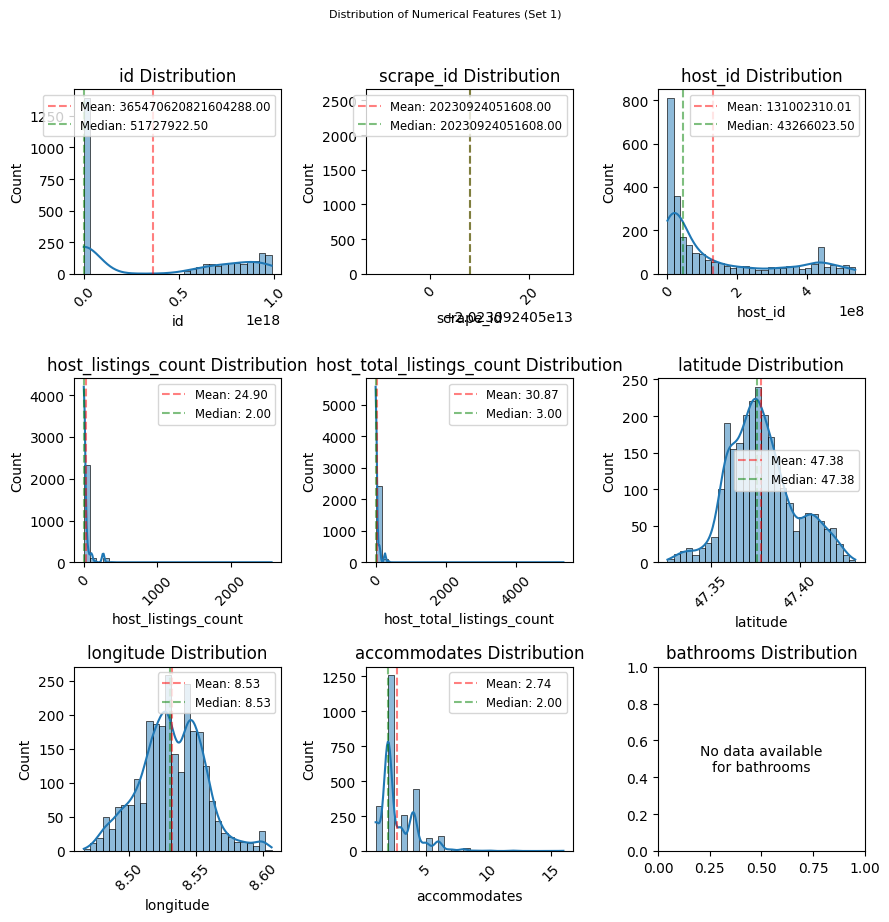

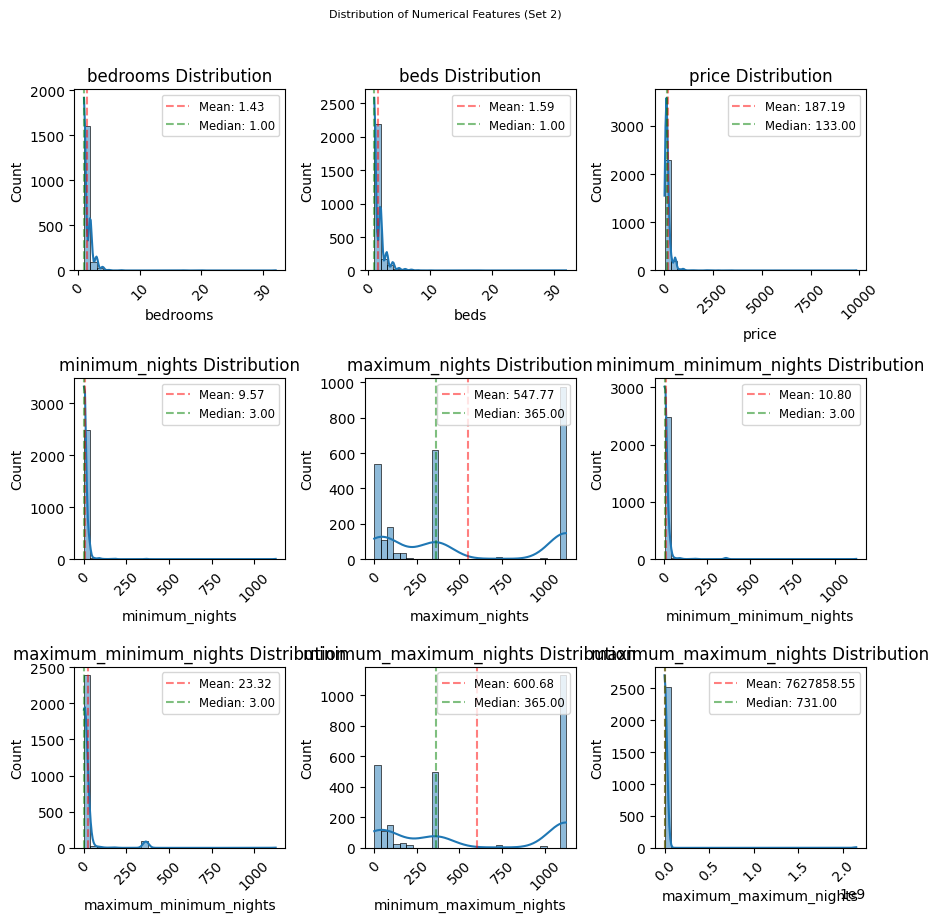

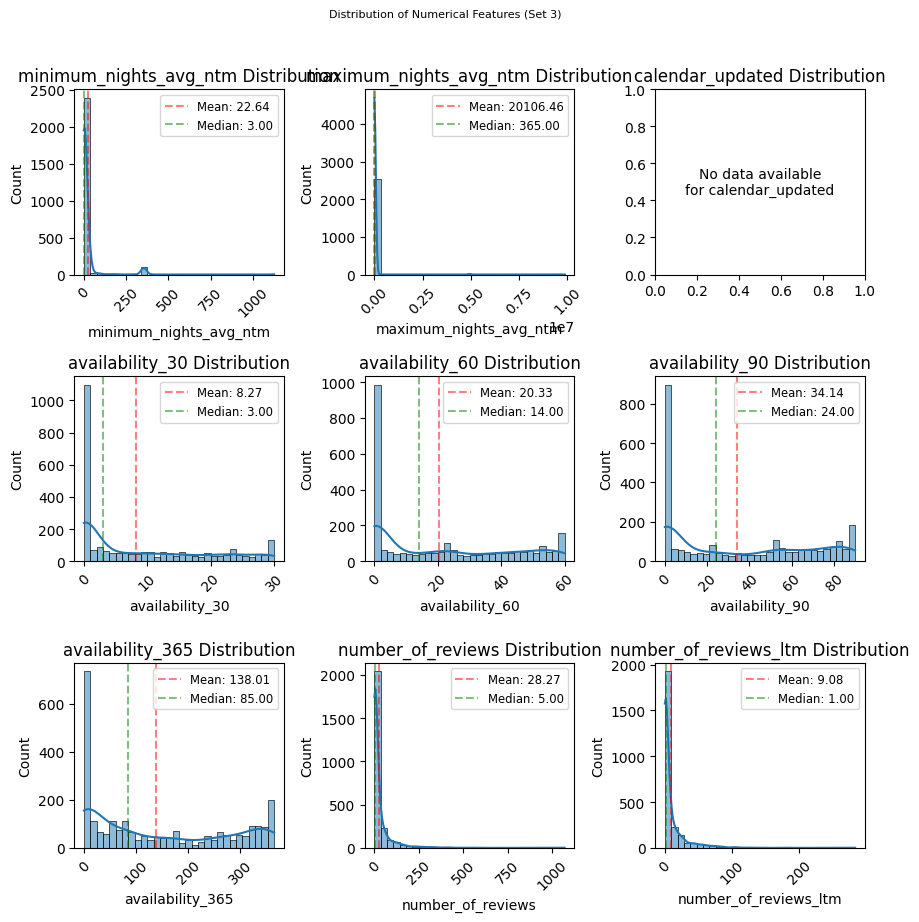

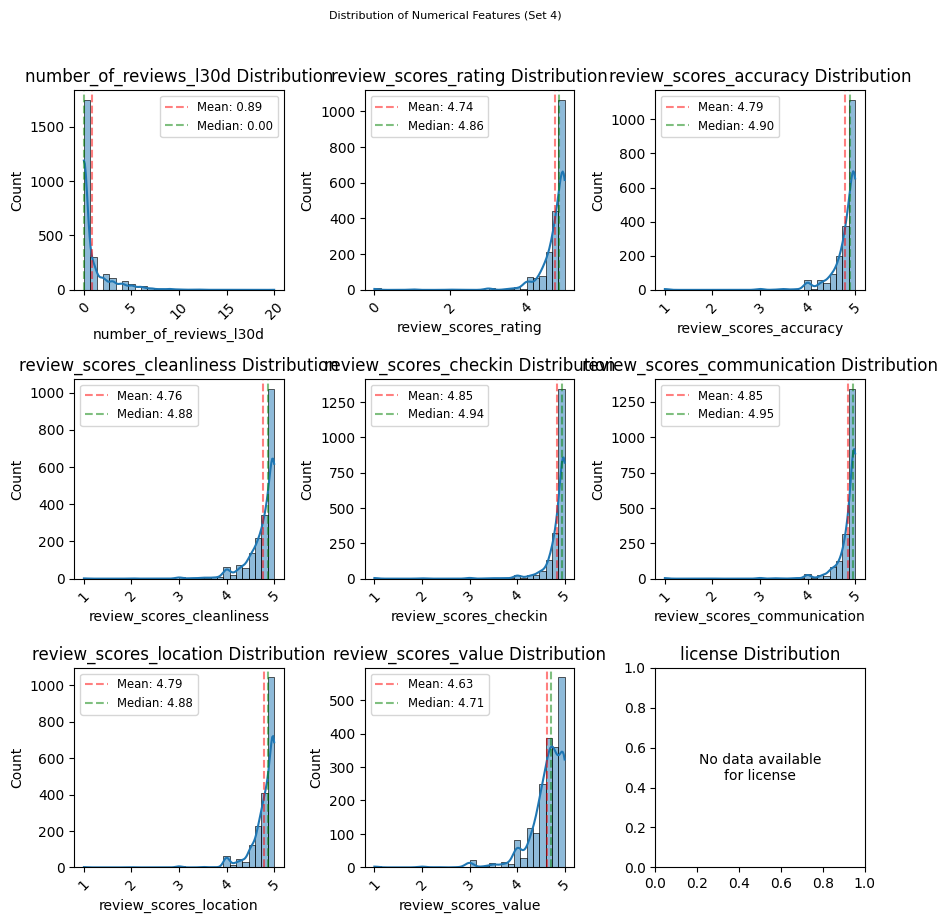

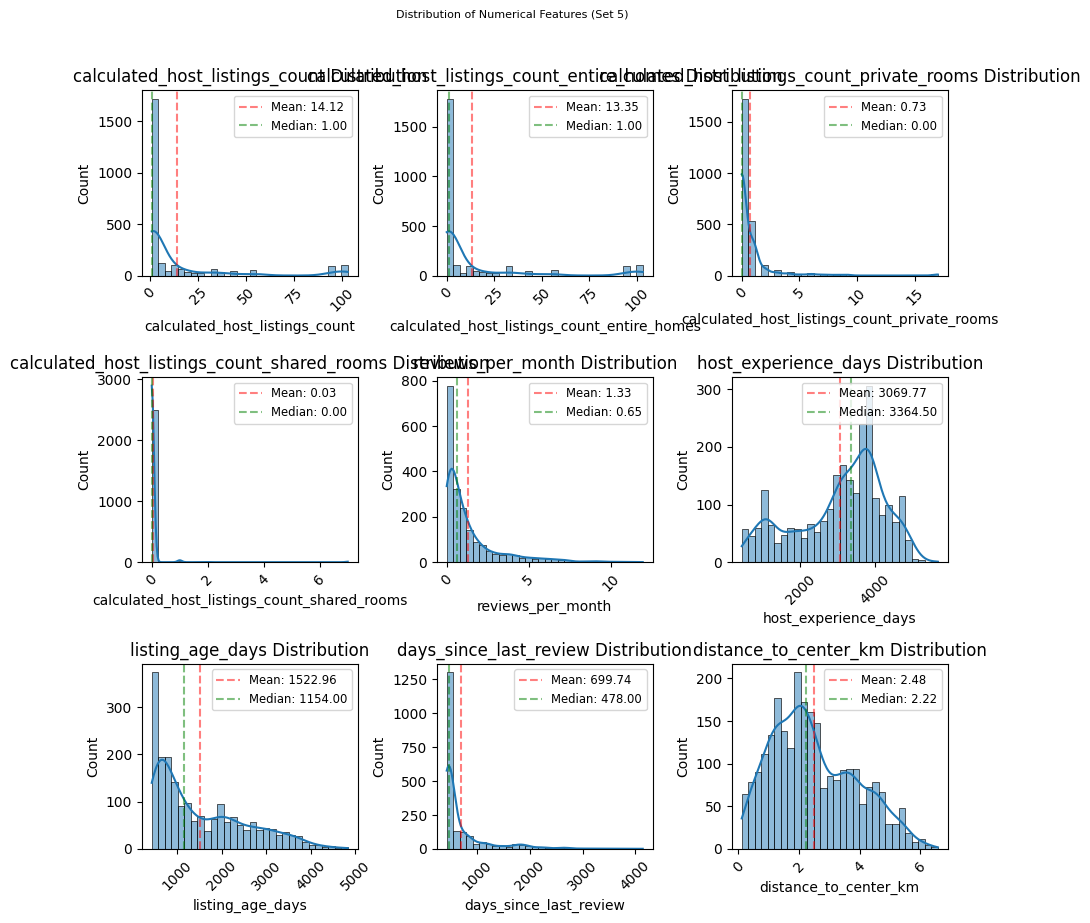

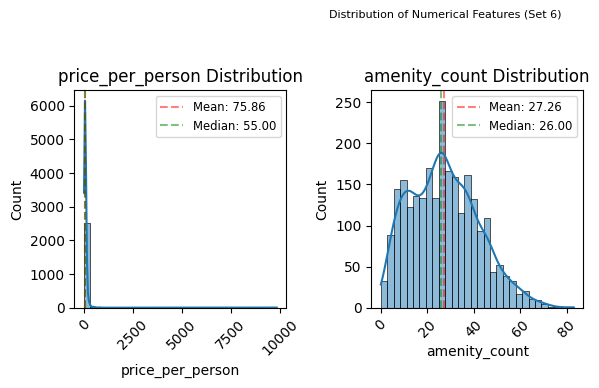

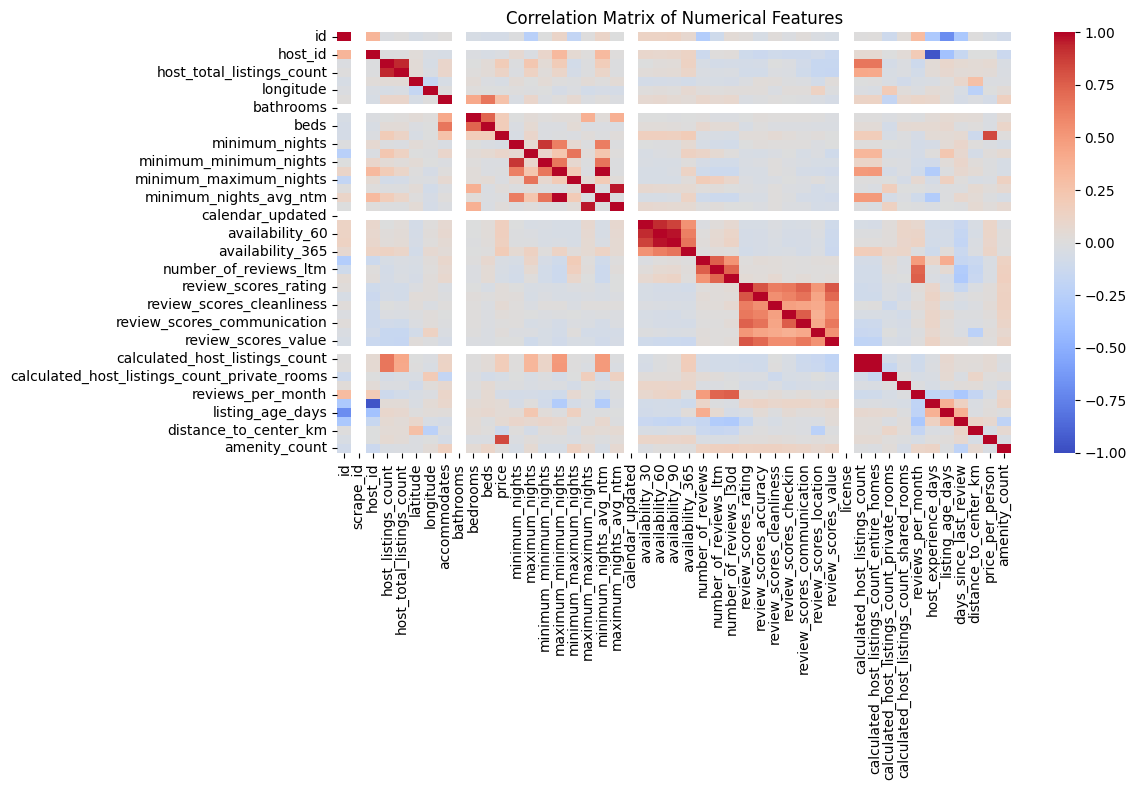

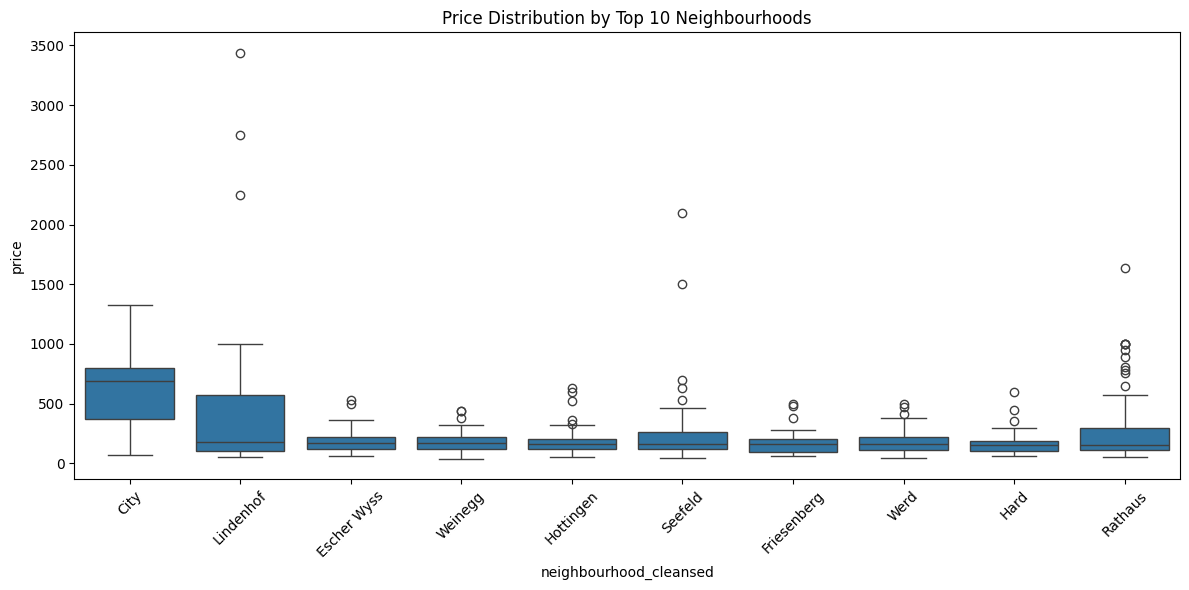

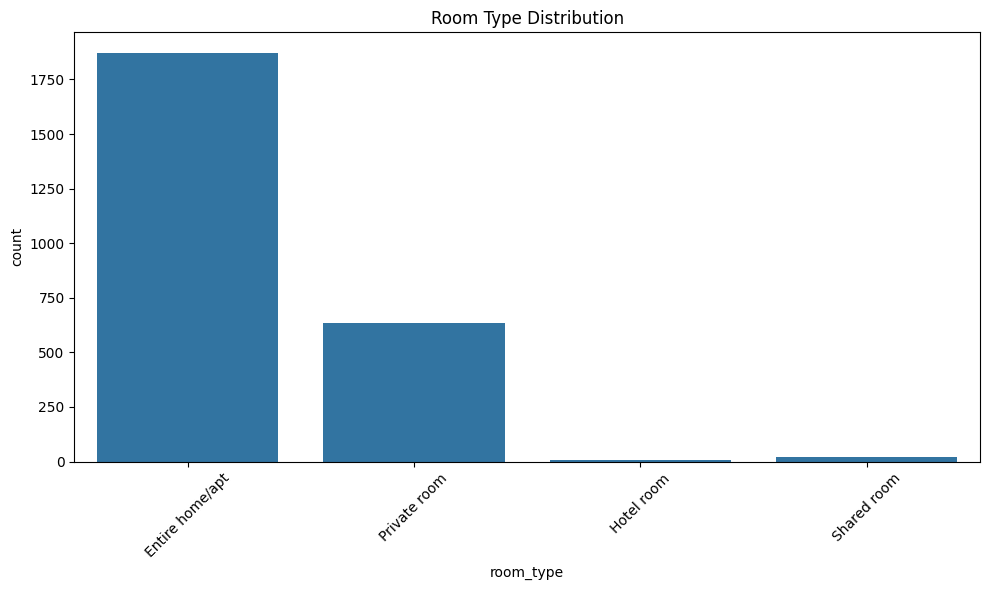

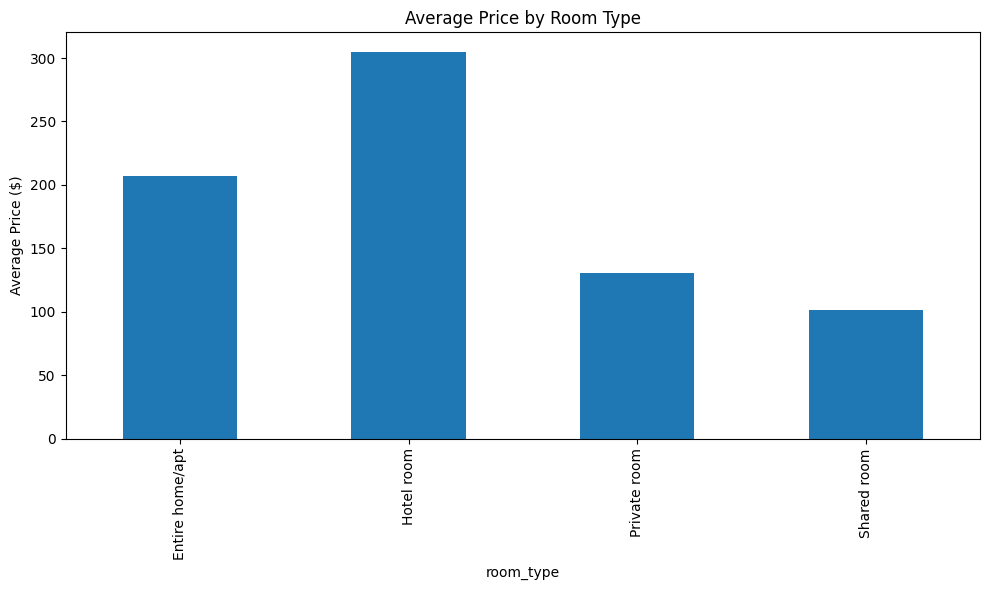

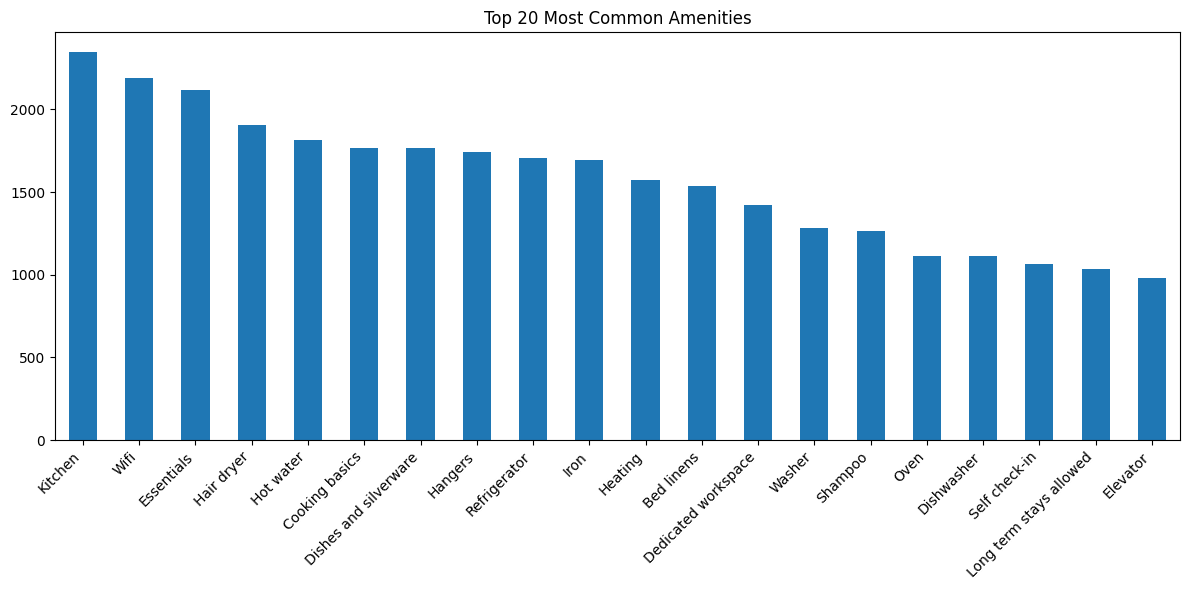

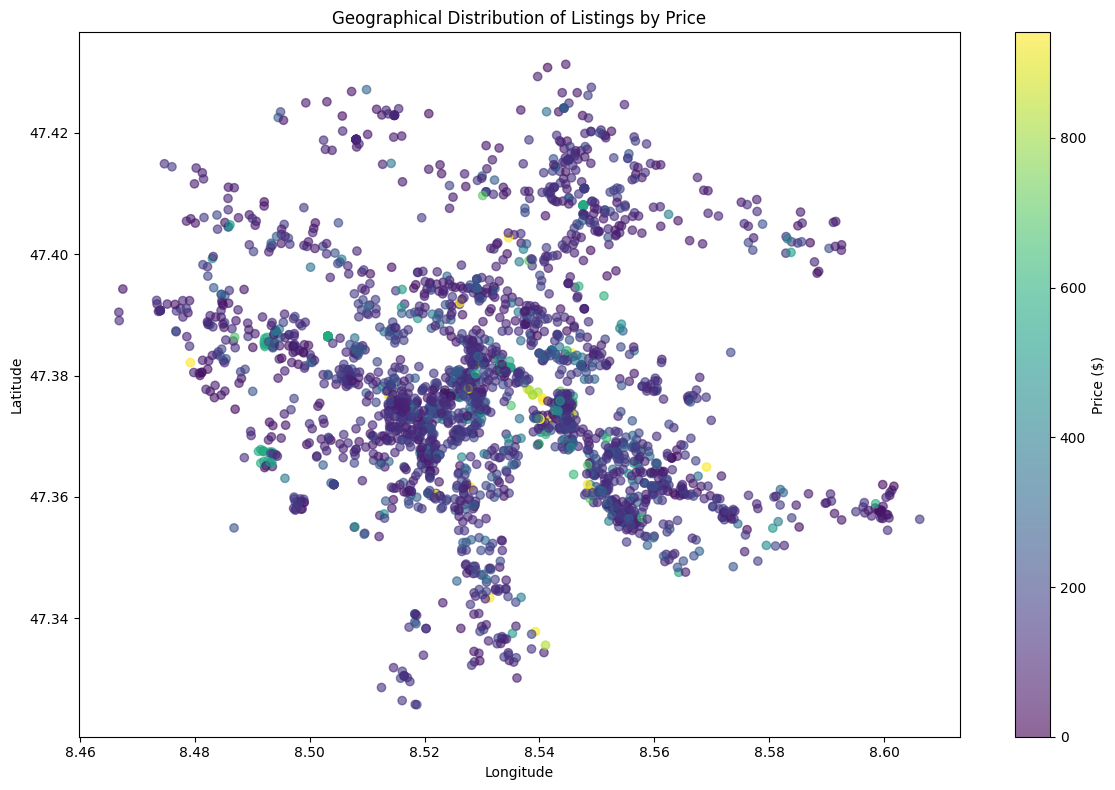

\data_quality comments:

1. missing vals
    cols with >50% missing vals:
   neighborhood_overview, host_neighbourhood, neighbourhood, bathrooms, calendar_updated, license
    cols with 20-50% missing vals:
   host_about, host_response_time, host_response_rate, bedrooms, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, reviews_per_month, listing_age_days, days_since_last_review
    cols with <20% missing vals:
   description, host_location, host_acceptance_rate, host_is_superhost, bathrooms_text, beds

2. Outliers
    host_listings_count: 280 outliers (3x IQR method)
    host_total_listings_count: 306 outliers (3x IQR method)
    accommodates: 6 outliers (3x IQR method)
    bedrooms: 5 outliers (3x IQR method)
    beds: 29 outliers (3x IQR method)
    price: 153 outliers (3x IQR method)
    minimum_nights: 243 outliers (3x IQR method)
    m

In [7]:
analyse_numerical_features(listings_processed)
analyse_categorical_features(listings_processed)
analyse_geographical_distribution(listings_processed)

outlier_info = detect_outliers(listings_processed)
data_quality = analyse_data_quality(listings_processed, outlier_info)

print(r"\data_quality comments:")
print("=========================================")
for category, items in data_quality.items():
    print(f"\n{category}")
    if items:  # Only print items if they exist
        for item in items:
            print(f"    {item}")

## other datasets


In [8]:
tourism_data = pd.read_csv("local_data/tourism.csv").dropna()
noise_data = pd.read_csv("local_data/noise_data_cleaned.csv").dropna()

## distance features


In [9]:
def calculate_noise_features(
    listings: pd.DataFrame,
    noise_data: pd.DataFrame,
    max_distance: float = 0.5,  # 500m radius
    decay_distance: float = 0.05,  # 50m half-life decay
    k: (int | None) = 50,  # Maximum number of neighbors to consider, None for all within max_distance
) -> pd.DataFrame:
    """
    Calculate noise features for each listing based on nearby noise measurements.
    Uses exponential decay where the influence halves every decay_distance.

    Args:
        listings: DataFrame containing listings with latitude and longitude
        noise_data: DataFrame containing noise measurements with lat, lon, and noise levels
        max_distance: Maximum distance in km to consider noise sources
        decay_distance: Distance in km at which the weight becomes 0.5 (half-life)
        k: Maximum number of neighbors to consider. If None, considers all points within max_distance

    Returns:
        DataFrame with noise features added
    """
    listings = listings.copy()

    # Build KD-tree for efficient nearest neighbor search
    noise_coords = noise_data[["latitude", "longitude"]].values
    tree = cKDTree(noise_coords)

    # Query tree for each listing
    listing_coords = listings[["latitude", "longitude"]].values
    max_dist_degrees = max_distance / 111

    # Set k to either the specified value or all points
    query_k = len(noise_data) if k is None else min(k, len(noise_data))

    # Single query with the determined k
    distances, indices = tree.query(listing_coords, k=query_k, distance_upper_bound=max_dist_degrees, workers=-1)

    # Convert distances to kilometers
    distances = distances * 111

    # Create masks for valid indices and distances
    valid_mask = indices < len(noise_data)
    distance_mask = distances <= max_distance
    combined_mask = valid_mask & distance_mask

    # Initialize arrays for noise values
    day_noise = np.zeros_like(distances)
    night_noise = np.zeros_like(distances)

    # Fill in valid noise values
    day_noise[valid_mask] = noise_data["lr_day"].values[indices[valid_mask]]
    night_noise[valid_mask] = noise_data["lr_night"].values[indices[valid_mask]]

    # Calculate weights using half-life decay formula: weight = 2^(-distance/decay_distance)
    weights = np.zeros_like(distances)
    weights[combined_mask] = 2 ** (-distances[combined_mask] / decay_distance)

    # Calculate weighted sums
    listings["noise_day"] = np.sum(day_noise * weights, axis=1)
    listings["noise_night"] = np.sum(night_noise * weights, axis=1)

    # Add count of points used (optional - remove if memory is still an issue)
    listings["noise_points_within_radius"] = np.sum(combined_mask, axis=1)

    return listings


def calculate_tourism_features(
    listings: pd.DataFrame,
    tourism_data: pd.DataFrame,
    max_distance: float = 1.0,  # 1km radius
    decay_distance: float = 0.1,  # 100m half-life decay
    k: (int | None) = 50,  # Maximum number of neighbors to consider, None for all within max_distance
) -> pd.DataFrame:
    """
    Calculate tourism features for each listing based on nearby points of interest.
    Uses exponential decay where the influence halves every decay_distance.

    Args:
        listings: DataFrame containing listings with latitude and longitude
        tourism_data: DataFrame containing tourism POIs with lat, lon, and type
        max_distance: Maximum distance in km to consider tourism points
        decay_distance: Distance in km at which the weight becomes 0.5 (half-life)
        k: Maximum number of neighbors to consider. If None, considers all points within max_distance

    Returns:
        DataFrame with tourism features added for each type
    """
    listings = listings.copy()

    # Build KD-tree for efficient nearest neighbor search
    tourism_coords = tourism_data[["latitude", "longitude"]].values
    tree = cKDTree(tourism_coords)

    # Query tree for each listing
    listing_coords = listings[["latitude", "longitude"]].values
    max_dist_degrees = max_distance / 111

    # Set k to either the specified value or all points
    query_k = len(tourism_data) if k is None else min(k, len(tourism_data))

    # Single query with the determined k
    distances, indices = tree.query(listing_coords, k=query_k, distance_upper_bound=max_dist_degrees, workers=-1)

    # Convert distances to kilometers
    distances = distances * 111

    # Create masks for valid indices and distances
    valid_mask = indices < len(tourism_data)
    distance_mask = distances <= max_distance
    combined_mask = valid_mask & distance_mask

    # Calculate weights using half-life decay formula: weight = 2^(-distance/decay_distance)
    weights = np.zeros_like(distances)
    weights[combined_mask] = 2 ** (-distances[combined_mask] / decay_distance)

    # Process each unique type of tourism point
    for poi_type in tourism_data["type"].unique():
        # Create type-specific mask
        type_indices = indices.copy()
        type_indices[~valid_mask] = 0
        type_mask = tourism_data["type"].values[type_indices] == poi_type
        type_mask = type_mask & combined_mask

        # Calculate type-specific weights and sum
        type_weights = np.zeros_like(distances)
        type_weights[type_mask] = weights[type_mask]

        # Calculate score for this type
        listings[f"tourism_{poi_type.lower().replace(' ', '_')}"] = np.sum(type_weights, axis=1)

    # Add total tourism score and count
    listings["tourism_total"] = np.sum(weights, axis=1)
    listings["tourism_points_within_radius"] = np.sum(combined_mask, axis=1)

    return listings

### test distance features


#### noise


In [20]:
try:
    print("Creating noise features...")
    listings_with_noise = calculate_noise_features(
        listings=listings_processed,
        noise_data=noise_data,
        max_distance=1,
        decay_distance=0.01,
        k=10000,
    )

    # Show new features
    noise_cols = [col for col in listings_with_noise.columns if col.startswith("noise_")]

    print("\nNoise features:")
    print(listings_with_noise[noise_cols].describe())
    print("\nCorrelations of new features with price:")
    print(listings_with_noise.filter(["price"] + noise_cols).corr()["price"].sort_values(ascending=False))


except Exception as e:
    print(f"Error occurred: {e!s}")
    print("\nDataset sizes:")
    print(f"Listings: {len(listings_processed)}")
    print(f"Noise data: {len(noise_data)}")

Creating noise features...

Noise features:
          noise_day   noise_night  noise_points_within_radius
count   2534.000000   2534.000000                 2534.000000
mean    3444.601215   2841.179597                 9996.053670
std     1947.083775   1645.506506                  198.653717
min        0.000000      0.000000                    0.000000
25%     1934.688391   1546.679230                10000.000000
50%     3313.815632   2749.333244                10000.000000
75%     5020.022980   4126.813140                10000.000000
max    11857.345132  10458.397543                10000.000000

Correlations of new features with price:
price                         1.000000
noise_night                   0.060817
noise_day                     0.057494
noise_points_within_radius   -0.003599
Name: price, dtype: float64


#### tourism


In [16]:
try:
    print("Creating tourism features...")
    listings_with_tourism = calculate_tourism_features(
        listings_processed,
        tourism_data,
        max_distance=2.0,  # 2km radius
        decay_distance=0.1,  # 100m half-life (less steep decay than noise)
        k=None,
    )

    # Show new features
    tourism_cols = [col for col in listings_with_tourism.columns if col.startswith("tourism_")]
    print("\nTourism features:")
    print(listings_with_tourism[tourism_cols].describe())

    # Show example of high-tourism areas
    print("\nTop 5 locations by total tourism score:")
    print(
        listings_with_tourism.nlargest(5, "tourism_total")[
            ["latitude", "longitude", "tourism_total"] + [col for col in tourism_cols if col != "tourism_total"]
        ]
    )
    print("\nCorrelations of new features with price:")
    print(listings_with_tourism.filter(["price"] + tourism_cols).corr()["price"].sort_values(ascending=False))

except Exception as e:
    print(f"Error occurred: {e!s}")
    print("\nDataset sizes:")
    print(f"Listings: {len(listings_processed)}")
    print(f"Tourism data: {len(tourism_data)}")

Creating tourism features...

Tourism features:
       tourism_barorpub  tourism_bedandbreakfast  tourism_cafeorcoffeeshop  \
count       2534.000000              2534.000000               2534.000000   
mean           0.558582                 0.001750                  0.082223   
std            1.179007                 0.034791                  0.223266   
min            0.000000                 0.000000                  0.000000   
25%            0.000000                 0.000000                  0.000000   
50%            0.007802                 0.000000                  0.000578   
75%            0.503911                 0.000000                  0.036035   
max            7.324231                 0.990684                  1.678792   

       tourism_campground  tourism_casino  tourism_church  \
count         2534.000000     2534.000000     2534.000000   
mean             0.000616        0.001807        0.036564   
std              0.017818        0.012098        0.162413   
min  